In [1]:
import numpy as np
import scipy.signal as signal
import xarray as xr
import matplotlib.pyplot as plt

# Constants
CP = 1004
G = 9.81
LF = 0.3336e+06  # Latent heat of fusion, J/kg
LS = 2.8440e+06  # Latent heat of sublimation, J/kg
LV = LS - LF      # Latent heat of vaporization

# Inputs
NX = 256
NY = 256
NZ = 64
DATE = 20221230
BC = '_DCa' ### SST varying SOLIN varying EXPT_sw
NOTES = '(SOLIN)'
DAYS = [51, 57]
DAY_START = 24 * (DAYS[0] - 1)
DAY_END = 24 * DAYS[1]
TIME_STEP = np.arange(1080 * 8 * DAYS[0], 1080 * 8 * (DAYS[1] + 1), 1080)

# Locate nc files
JOB = f'SAM6108_RCE_MC_{DATE:8d}_{NX:03d}x{NY:03d}{BC}'
PATH = f'/fs3/group/mullegrp/Bidyut_Goswami/sam_data/{JOB}/OUT_{JOB}/NETCDF_files/'



In [2]:
f_in=f'{PATH}RCE_MC_{JOB}.nc'
f_in

'/fs3/group/mullegrp/Bidyut_Goswami/sam_data/SAM6108_RCE_MC_20221230_256x256_DCa/OUT_SAM6108_RCE_MC_20221230_256x256_DCa/NETCDF_files/RCE_MC_SAM6108_RCE_MC_20221230_256x256_DCa.nc'

In [3]:
# Read 1D nc files
TOTRHO = xr.open_dataset(f'{PATH}RCE_MC_{JOB}.nc')['RHO']



In [4]:
# Read 2D nc files
TOTMSE = xr.concat([xr.open_dataset(f'{PATH}RCE_MC_{JOB}_{NZ}.2Dcom_{i}.nc')['MSE'] for i in range(1, 4)], dim='time')



In [5]:
import dask.array as da
import dask

# Read 3D nc files lazily using Dask
W_ds = xr.concat([xr.open_dataset(f'{PATH}RCE_MC_{JOB}_{NZ}_{t:010d}.nc', chunks={'time': 'auto'})['W'] for t in TIME_STEP], dim='time')
TABS = xr.concat([xr.open_dataset(f'{PATH}RCE_MC_{JOB}_{NZ}_{t:010d}.nc', chunks={'time': 'auto'})['TABS'] for t in TIME_STEP], dim='time')
QV = xr.concat([xr.open_dataset(f'{PATH}RCE_MC_{JOB}_{NZ}_{t:010d}.nc', chunks={'time': 'auto'})['QV'] for t in TIME_STEP], dim='time')

# Extract data of the day(s) chosen
RHO = TOTRHO.values[DAY_START:DAY_END, :]
MSE = TOTMSE.values[DAY_START:DAY_END, :, :]
W = da.from_array(W_ds.values, chunks='auto')
TABS = da.from_array(TABS.values, chunks='auto')
QV = da.from_array(QV.values, chunks='auto')

In [6]:
# Averaging over the day(s)
RHO_MEAN = np.mean(RHO, axis=0)
MSE_MEAN = np.mean(MSE, axis=0)

# Compute the mean of W, TABS, and QV while considering chunks
W_MEAN = W.mean(axis=0).compute()
TABS_MEAN = TABS.mean(axis=0).compute()
QV_MEAN = QV.mean(axis=0).compute()


In [7]:
#RHO has 64 vertical levels while other variables have 53 levels.
#Therefore trimming RHO to the size of other variables

RHO_MEAN_TRIMMED = RHO_MEAN[:TABS.shape[1]]

In [8]:
print("Shape of RHO_MEAN_TRIMMED:", RHO_MEAN_TRIMMED.shape)
print("Shape of MSE_MEAN:", MSE_MEAN.shape)
print("Shape of W_MEAN:", W_MEAN.shape)
print("Shape of TABS_MEAN:", TABS_MEAN.shape)
print("Shape of QV_MEAN:", QV_MEAN.shape)

Shape of RHO_MEAN_TRIMMED: (53,)
Shape of MSE_MEAN: (256, 256)
Shape of W_MEAN: (53, 256, 256)
Shape of TABS_MEAN: (53, 256, 256)
Shape of QV_MEAN: (53, 256, 256)


In [9]:
# Get z values from the original xarray dataset
Z = W_ds.coords['z'].values

# Reshape Z to match the dimensions of TABS_MEAN
Z_reshaped = Z.reshape((Z.shape[0], 1, 1))
ZZ = np.broadcast_to(Z_reshaped, TABS_MEAN.shape)

# Calculate moist static energy
MSE3D = CP * TABS_MEAN + G * ZZ + LV * QV_MEAN * 10**-3

In [10]:
print("Shape of MSE3D:", MSE3D.shape)

Shape of MSE3D: (53, 256, 256)


In [11]:
# Coarsening using SciPy
BLOCK = 1
C_MSE = signal.convolve2d(MSE_MEAN, np.ones((BLOCK, BLOCK)), 'valid')[::BLOCK, ::BLOCK] / BLOCK**2
SUM_W = np.array([signal.convolve2d(W_MEAN[i, :, :], np.ones((BLOCK, BLOCK)), 'valid')[::BLOCK, ::BLOCK] for i in range(len(Z))])
C_MSE3D   = np.array([signal.convolve2d(MSE3D[i, :, :],      np.ones((BLOCK, BLOCK)), 'valid')[::BLOCK, ::BLOCK] / BLOCK**2 for i in range(len(Z))])

In [12]:
print("Shape of C_MSE:", C_MSE.shape)
print("Shape of C_MSE3D:", C_MSE3D.shape)
print("Shape of SUM_W:", SUM_W.shape)

Shape of C_MSE: (256, 256)
Shape of C_MSE3D: (53, 256, 256)
Shape of SUM_W: (53, 256, 256)


In [13]:
#Reshape C_MSE

reshaped_MSE=np.reshape(C_MSE, int(NX*NY/BLOCK**2))

In [14]:
###########################################################
###########################################################

In [15]:
#CJ
print("Shape of RHO_MEAN_TRIMMED:", RHO_MEAN_TRIMMED.shape)
print("Shape of MSE_MEAN:", MSE_MEAN.shape)
print("Shape of W_MEAN:", W_MEAN.shape)
print("Shape of TABS_MEAN:", TABS_MEAN.shape)
print("Shape of QV_MEAN:", QV_MEAN.shape)
print("Shape of MSE3D:", MSE3D.shape)
print("Shape of C_MSE:", C_MSE.shape)



Shape of RHO_MEAN_TRIMMED: (53,)
Shape of MSE_MEAN: (256, 256)
Shape of W_MEAN: (53, 256, 256)
Shape of TABS_MEAN: (53, 256, 256)
Shape of QV_MEAN: (53, 256, 256)
Shape of MSE3D: (53, 256, 256)
Shape of C_MSE: (256, 256)


In [16]:
#Reshape SUM_W and C_H from (53,8,8) to (64,53)
BLOCK=1

reshaped_MSE=np.reshape(MSE_MEAN, int(NX*NY/BLOCK**2))
reshaped_W=np.reshape(W_MEAN, (len(Z), int(NX*NY/BLOCK**2))).T
reshaped_MSE3D=np.reshape(MSE3D, (len(Z), int(NX*NY/BLOCK**2))).T

print("Shape of reshaped_W:", reshaped_W.shape)
print("Shape of reshaped_MSE3D:", reshaped_MSE3D.shape)

idx = np.argsort(reshaped_MSE, axis=None)  # Flatten the array for sorting
C_MSE_sorted = np.sort(reshaped_MSE, axis=None)
MSE_bins=np.linspace(C_MSE_sorted[0],C_MSE_sorted[-1],100)

nb_MSE_bins=len(MSE_bins)-1
nz=RHO_MEAN_TRIMMED.shape[0]


summed_W= np.zeros((nb_MSE_bins,nz))

#print("Shape of summed_W:", summed_W.shape)

#Calculate total mass flux in each bin
for j in range(nz):
    for i in range(nb_MSE_bins-1):

 #       print("i,j", i,j)
  #      print("size summed_W", summed_W.shape)
        
        
        summed_W[i,j]=np.sum( (reshaped_MSE[:]>MSE_bins[i]) * (reshaped_MSE[:]<=MSE_bins[i+1]) * reshaped_W[:,j] )
    

# Calculate effective streamfunction
PSI = np.zeros((nb_MSE_bins,nz))



for j in range(nz):
    PSI[0, j] = 0
    for i in range(nb_MSE_bins-1):
        PSI[i+1, j] = PSI[i, j] + RHO_MEAN_TRIMMED[j] * summed_W[i, j]


print("Shape of psi:", PSI.shape)




Shape of reshaped_W: (65536, 53)
Shape of reshaped_MSE3D: (65536, 53)
Shape of psi: (99, 53)


In [17]:
# Apply the sorted indices to sort reshaped_MSE3D
sorted_MSE3D = reshaped_MSE3D[idx,:]

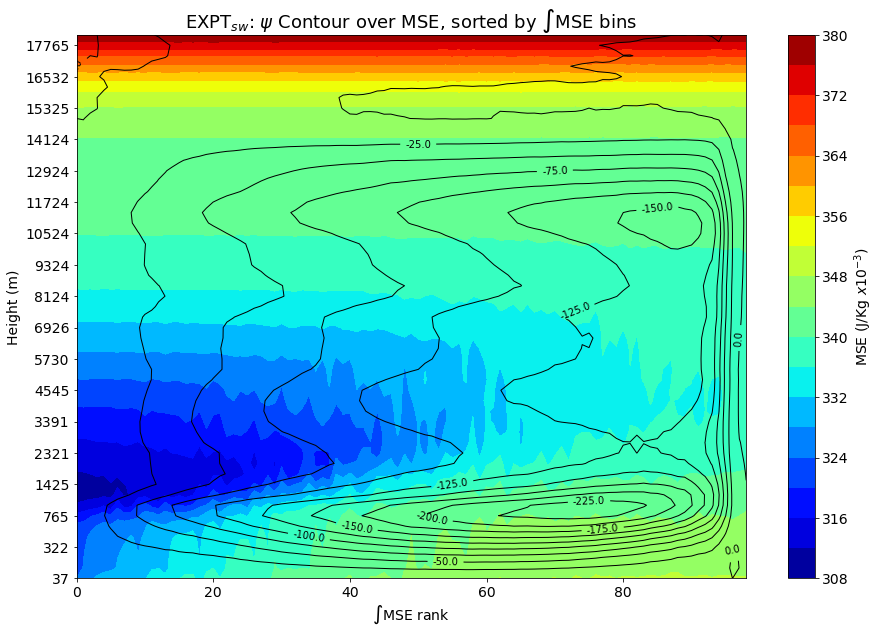

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d


psi=PSI

# Interpolate sorted_MSE3D to match the shape of psi
x_old = np.linspace(0, 1, sorted_MSE3D.shape[0])
x_new = np.linspace(0, 1, psi.shape[0])
sorted_MSE3D_interp = np.zeros_like(psi)

for i in range(sorted_MSE3D.shape[1]):
    interp_func = interp1d(x_old, sorted_MSE3D[:, i], kind='linear')
    sorted_MSE3D_interp[:, i] = interp_func(x_new)

# # Define Z array for y-axis tick labels
Z = W_ds.coords['z'].values

# Plotting
fig, ax = plt.subplots(figsize=(15, 10))

# Setting the both-axis label fontsize
ax.tick_params(axis='both', labelsize=14)

# Plot interpolated sorted_MSE3D
c = ax.contourf(sorted_MSE3D_interp.T/1000, levels=20, cmap='jet')
# Adding the colorbar
cbar = fig.colorbar(c, ax=ax)
cbar.set_label('MSE (J/Kg $x 10^{-3}$)', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Overlay psi contours
contours = ax.contour(psi.T, levels=10, colors='k', linewidths=1, linestyles='solid')
ax.clabel(contours, inline=True, fontsize=10, fmt='%1.1f')
# # Overlay psi contours
# ax.contour(psi.T, levels=10, colors='k', linewidths=1)

# Set y-axis tick labels to every 3rd value in Z
every_3rd_index = np.arange(0, len(Z), 3)
ax.set_yticks(every_3rd_index)
ax.set_yticklabels([f'{int(Z[i])}' for i in every_3rd_index])

ax.set_title('EXPT$_{sw}$: $\psi$ Contour over MSE, sorted by $\int$MSE bins',fontsize=18)
ax.set_xlabel('$\int$MSE rank', fontsize=14)  # Set appropriate labels
ax.set_ylabel('Height (m)', fontsize=14)   # Set appropriate labels

#Saving figure
fig_directory='/fs3/home/bgoswami/work/20220913_SAM/SAM_Manuscript_01/Final_Figs'
figname="Figure_5"

plt.savefig(''+str(fig_directory)+'/'+str(figname)+'.svg', format="svg",transparent=True, dpi=1200)
!rsvg-convert -f pdf -o {fig_directory}/{figname}.pdf {fig_directory}/{figname}.svg
plt.show()
